In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm

from data.io import Reader, Saver
from analyzer.model.regression_model import RegressionModel
from data.plot import Drawer
from analyzer.stat_criterion.stat_criteria import StatCriteria
from data.encoder import Encoder
from data.normalizer import Normalizer
from data import DataPreparation

from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.stats import kruskal, mannwhitneyu, chi2_contingency, chisquare, norm, ttest_1samp, ttest_ind, shapiro
from keras.src.layers import Dense
from keras import Sequential, Input
from keras import backend as K


In [2]:
# читаем датасет
csv_path = Reader.get_csv_path('notebooks\dataset', 'RK_554B_data.csv')
df_original = Reader.read_csv(csv_path)
df = df_original.copy().reset_index(drop=True)
df = df.drop('number', axis = 1)
mask = df['resistor'] != 6000
df = df[mask]
df.head(10)

,freq,r,c0,cq,q1000,tmax,rc/rb,resistor
0,-0.3,66.4,2.89,0.19,1248,84.0,1.42,7378
2,0.7,69.0,2.80,0.20,1172,80.2,1.34,9877
3,0.1,63.7,2.69,0.19,1337,82.2,1.38,8622
4,0.6,67.8,2.89,0.20,1185,82.8,1.31,8617
5,-0.4,67.5,2.87,0.19,1249,80.0,1.17,9355
6,-1.1,72.3,2.84,0.18,1210,84.3,1.40,8632
7,1.4,67.4,2.78,0.20,1188,80.4,1.41,9262
8,0.2,67.7,2.89,0.19,1213,86.5,1.38,6764
9,-0.6,70.4,2.81,0.19,1193,84.7,1.34,7535
10,-0.4,70.0,2.73,0.19,1193,80.9,1.38,8910


# Постановка задачи

найти значение compensation_resistor на основе использования поступающих входных данных

# Преобразование данных

In [3]:
# посмотрим на пропуски в данных
df.isna().sum()

freq        0
r           0
c0          0
cq          0
q1000       0
tmax        0
rc/rb       0
resistor    0
dtype: int64

In [4]:
# смотрим на типы данных и требования к памяти
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 177 entries, 0 to 182
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   freq      177 non-null    float64
 1   r         177 non-null    float64
 2   c0        177 non-null    float64
 3   cq        177 non-null    float64
 4   q1000     177 non-null    int64  
 5   tmax      177 non-null    float64
 6   rc/rb     177 non-null    float64
 7   resistor  177 non-null    int64  
dtypes: float64(6), int64(2)
memory usage: 12.4 KB


In [5]:
# Посмотрим статистику о датасете
df.describe()

,freq,r,c0,cq,q1000,tmax,rc/rb,resistor
count,177.000000,177.000000,177.000000,177.000000,177.000000,177.000000,177.000000,177.000000
mean,-0.247458,69.216949,2.829266,0.190113,1203.768362,83.469492,1.371977,8213.615819
std,1.102635,4.455939,0.158899,0.007150,64.772570,2.791582,0.064218,1062.141485
min,-7.800000,63.100000,1.010000,0.150000,867.000000,76.500000,1.110000,5366.000000
25%,-0.600000,66.300000,2.790000,0.190000,1176.000000,81.500000,1.350000,7408.000000
50%,-0.100000,68.100000,2.840000,0.190000,1206.000000,83.700000,1.380000,8216.000000
75%,0.400000,71.200000,2.890000,0.190000,1239.000000,85.400000,1.410000,8981.000000
max,4.600000,98.100000,3.210000,0.200000,1368.000000,93.600000,1.630000,11193.000000


# Проводим визуальный анализ

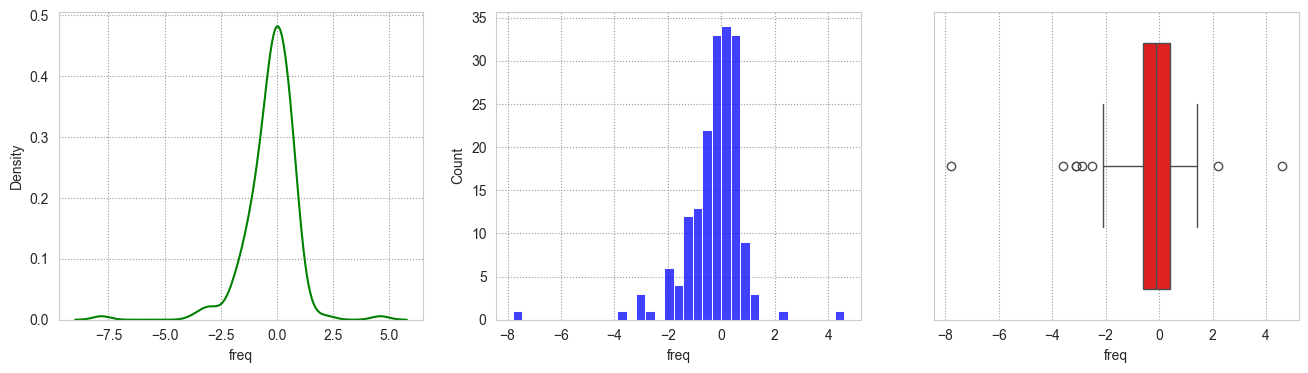

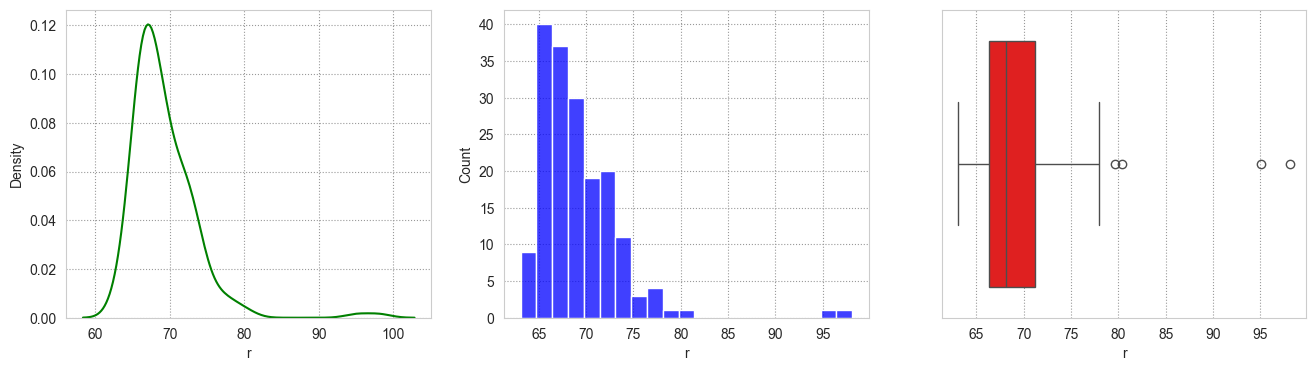

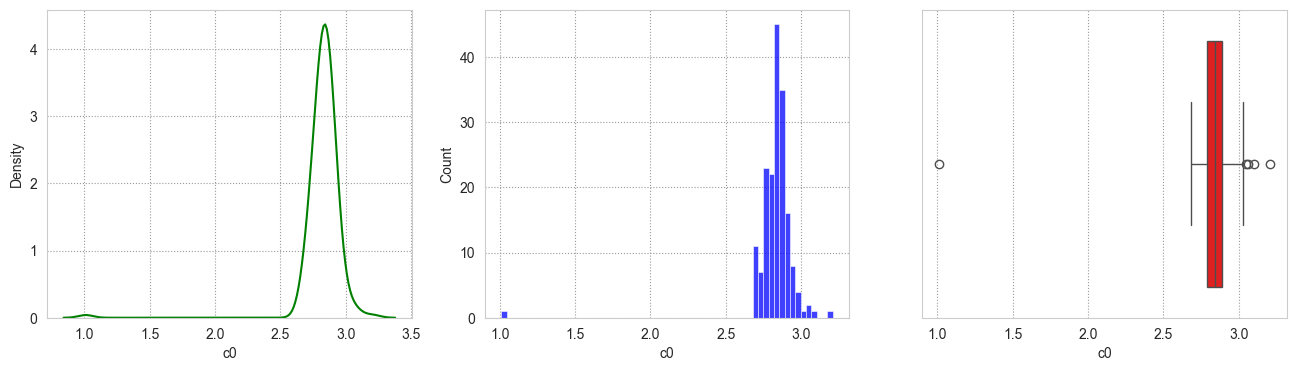

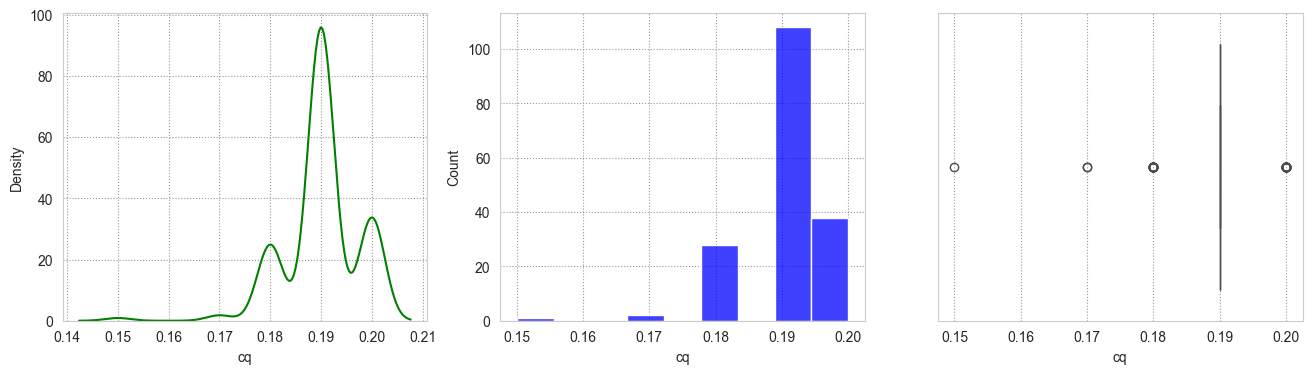

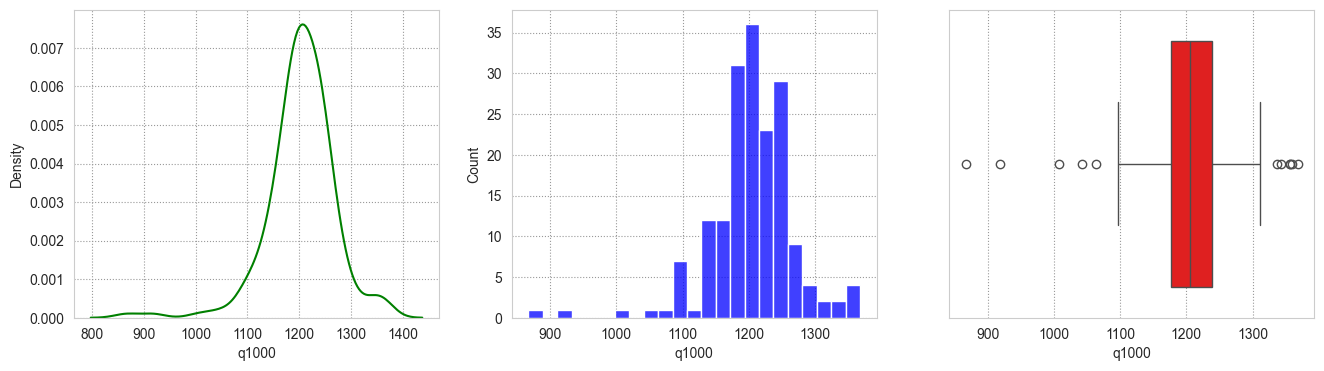

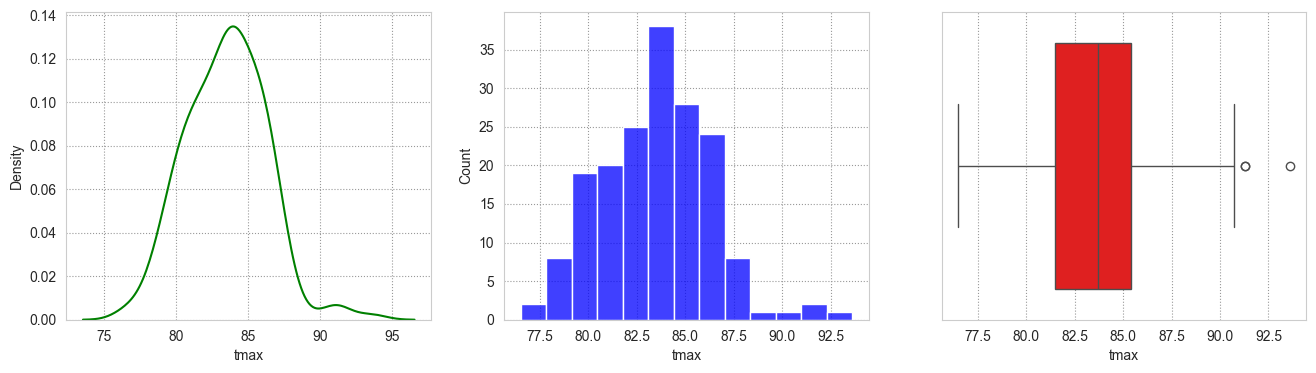

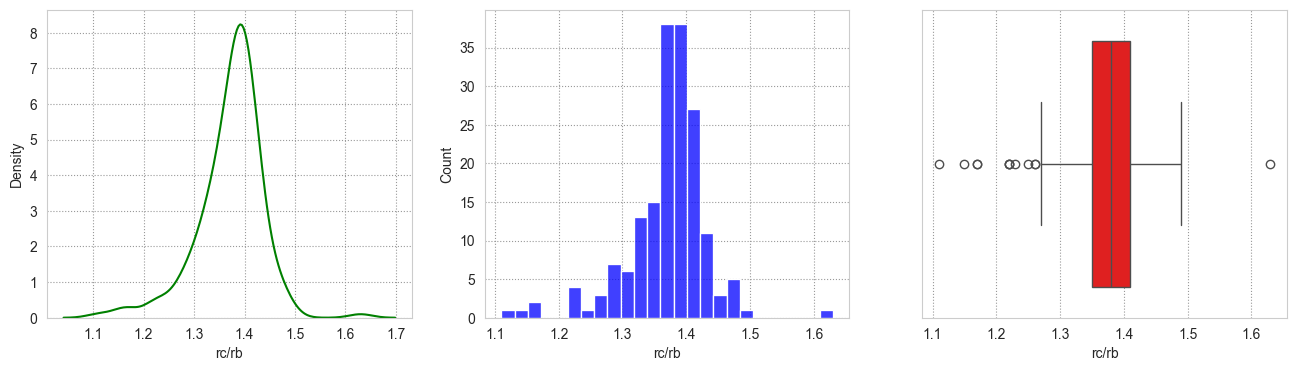

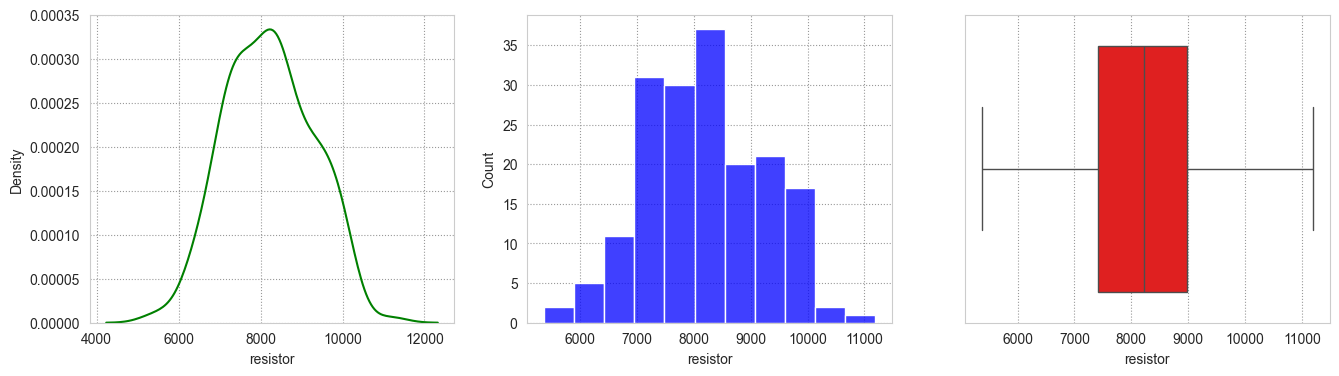

In [6]:
# Посмотрим на виды распределений "числовых" параметров и на ящики с усами
Drawer.plot_numeric_seaborn(df)

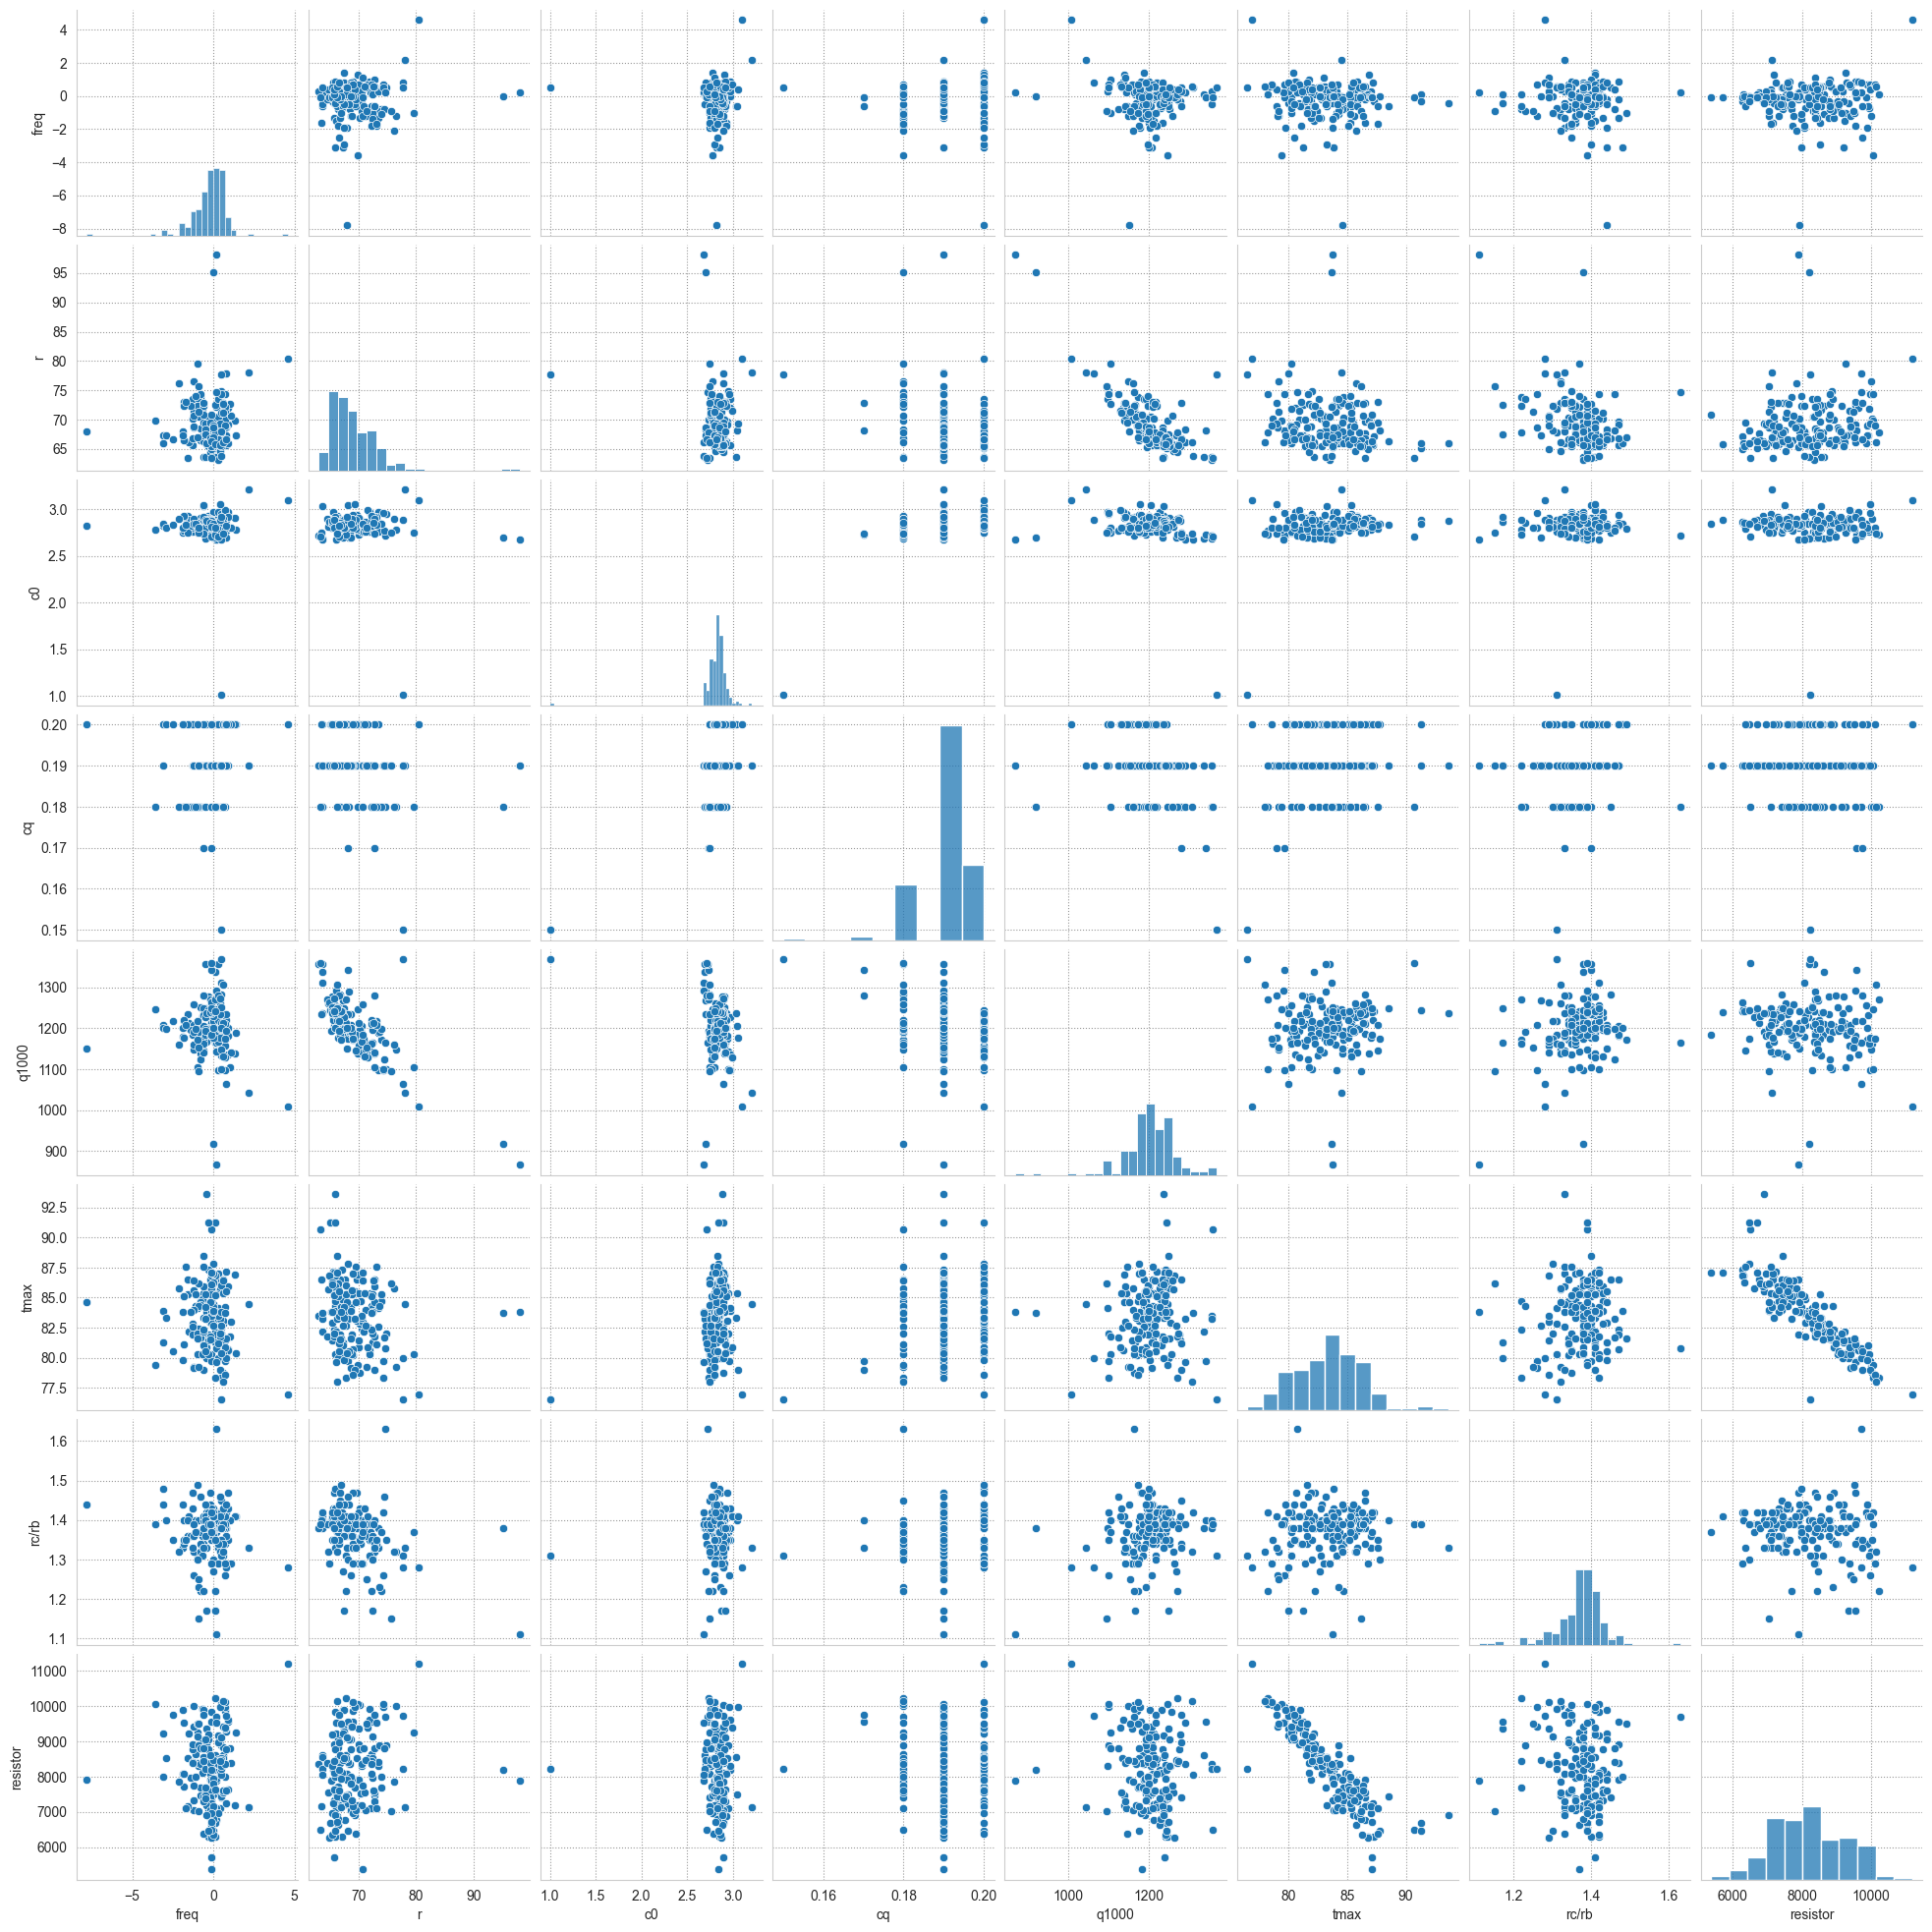

In [7]:
# Исследуем графически зависимость признаков на целевую переменную для обычной недвижимости
numeric_col = df.describe().columns
sns.pairplot(df[numeric_col])

# Анализ зависимости признаков

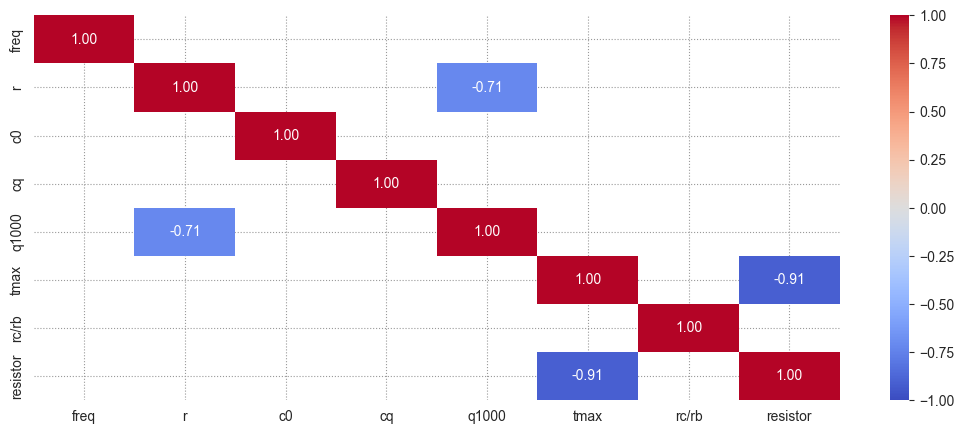

In [8]:
# Исследуем тепловую карту корреляции признаков 
Drawer.plot_heatmap(df, method='spearman')

In [9]:
df.columns

Index(['freq', 'r', 'c0', 'cq', 'q1000', 'tmax', 'rc/rb', 'resistor'], dtype='object')

In [10]:
# Проверим допущение о мультиколлинеарности
columns_list = ['resistor', 'freq', 'r', 'c0', 'cq', 'q1000']
numeric_col = df.drop(columns=columns_list).describe().columns
vif_data = pd.DataFrame()
vif_data.index = numeric_col

vif_data['VIF'] = [variance_inflation_factor(df[numeric_col].values, i) for i in range(len(numeric_col))]
vif_data

,VIF
tmax,341.982268
rc/rb,341.982268


In [11]:
df.head()

,freq,r,c0,cq,q1000,tmax,rc/rb,resistor
0,-0.3,66.4,2.89,0.19,1248,84.0,1.42,7378
2,0.7,69.0,2.80,0.20,1172,80.2,1.34,9877
3,0.1,63.7,2.69,0.19,1337,82.2,1.38,8622
4,0.6,67.8,2.89,0.20,1185,82.8,1.31,8617
5,-0.4,67.5,2.87,0.19,1249,80.0,1.17,9355


In [12]:
groups = [df['tmax'], df['resistor']]
stat, p_value = mannwhitneyu(*groups, alternative='two-sided')
print(p_value)

1.5850353815305625e-59


# Подготавливаем данные

In [13]:
df.columns

Index(['freq', 'r', 'c0', 'cq', 'q1000', 'tmax', 'rc/rb', 'resistor'], dtype='object')

In [14]:
# подготавливаем данные
target = ['resistor']
# exclude_features = ['resistor', 'q1000']
exclude_features = ['resistor', 'freq', 'r', 'c0', 'cq', 'q1000', 'rc/rb']

X_train, X_test, y_train, y_test = DataPreparation().train_test_split(df, exclude_features, target)

# проводим нормализацию
X_train, X_test, _ = Normalizer().MinMaxScaler(X_train, X_test)
y_train, y_test, scaler_y = Normalizer().MinMaxScaler(y_train, y_test)
X_train, X_test, y_train, y_test = Normalizer().reset_index(X_train, X_test, y_train, y_test)

# Создаём модель

In [15]:
# Применим метод OLS
y_test, y_pred, _ = RegressionModel().OLS(X_train, X_test, y_train, y_test)

                            OLS Regression Results                            
Dep. Variable:               resistor   R-squared:                       0.757
Model:                            OLS   Adj. R-squared:                  0.756
Method:                 Least Squares   F-statistic:                     406.1
Date:                Fri, 07 Feb 2025   Prob (F-statistic):           8.12e-42
Time:                        23:00:45   Log-Likelihood:                 129.62
No. Observations:                 132   AIC:                            -255.2
Df Residuals:                     130   BIC:                            -249.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
tmax          -0.9473      0.047    -20.151      0.0

In [16]:
# Применим метод Lasso
y_test, y_pred, _ = RegressionModel().Lasso(X_train, X_test, y_train, y_test)

R²: 0.645
MAE: 0.09
MAPE: 22%
RMSE: 0
MSE: 0
__________
Коэффициенты Lasso-регрессии:
tmax: -0.60


In [17]:
# Применим метод опорных векторов
y_test, y_pred, _ = RegressionModel().SVR(X_train, X_test, y_train, y_test, kernel='rbf', C=1.0, epsilon=0.01)

R²: 0.831
MAE: 0.06
MAPE: 15%
RMSE: 0
MSE: 0


In [18]:
# Определение метрик
def r2_score(y_test_, y_pred_):
    y_test_ = K.cast(y_test_, dtype='float64') 
    y_pred_ = K.cast(y_pred_, dtype='float64') 
    SS_res = K.sum(K.square(y_test_ - y_pred_))
    SS_tot = K.sum(K.square(y_test_ - K.mean(y_test_)))
    return 1 - SS_res / (SS_tot + K.epsilon())

def mape(y_test_, y_pred_):
    y_test_ = K.cast(y_test_, dtype='float64') 
    y_pred_ = K.cast(y_pred_, dtype='float64') 
    return K.mean(K.abs((y_test_ - y_pred_) / y_test_)) * 100

# Создание модели
model = Sequential()
model.add(Input(shape=(X_train.shape[1],)))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='tanh'))
model.add(Dense(1))  # Линейная активация для регрессии

# Компиляция модели
model.compile(optimizer='adam', loss='mean_squared_error', metrics=[r2_score, mape])

# Обучение модели
epochs = 15
history = model.fit(X_train, y_train, epochs=epochs, batch_size=8, validation_data=(X_test, y_test))

Epoch 1/15


AttributeError: module 'keras.api.backend' has no attribute 'cast'

<Axes: >

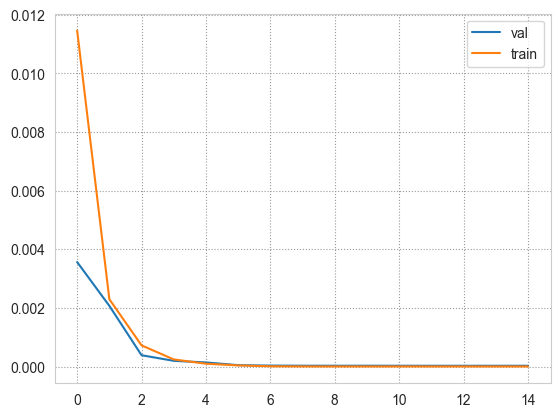

In [48]:
sns.lineplot(y=history.history['val_loss'], x=np.arange(epochs), label='val')
sns.lineplot(y=history.history['loss'], x=np.arange(epochs), label='train')
#history.history['val_loss']